# Upsampling: 2 methods
- Method 1: upsample each head, average the cross entropies from each head
- Method 2: mean pool attention logits from each head, upsample, calculate cross entropy

## Method 1

bc we actually have to run the model to have imgs to upsample, in this demonstrational notebook, I'm just gna downsample a gaze_mask to simulate what the model might output and then upsample it up again.

In [1]:
import torch
import torch.nn.functional as F
import math
from einops import repeat
from GABRIL_utils.gaze_to_mask import GazeToMask
from GABRIL_utils.utils import load_dataset
import sys


sys.path.append('..') 
data = torch.load('/project2/biyik_1165/nityakas/gaze_vit_v2/dev/dataset/Breakout/num_episodes_20_fs4_human.pt', weights_only=False)


In [2]:
env = 'Breakout'
seed = 42
datapath = 'dataset/'
conf_type='normal'
train_type = 'normal'
conf_randomness = 0.0
stack = 1
num_episodes = 2
use_gaze = True
gaze_method = 'Reg'
data_source = 'Our'
gaze_mask_sigma = 15.0
gaze_mask_coef = 0.7

patch_size = (14, 14)

In [3]:

bservations, actions, gaze_masks, gaze_coordinates = load_dataset(
        env=env,
        seed=seed,
        datapath='../dataset/',
        conf_type=conf_type,
        conf_randomness=conf_randomness,
        stack=stack,
        num_episodes=num_episodes,
        use_gaze=use_gaze,
        data_source=data_source,
        gaze_mask_sigma=gaze_mask_sigma,
        gaze_mask_coef=gaze_mask_coef              
    )

FileNotFoundError: [Errno 2] No such file or directory: '../dataset/Breakout/num_episodes_20_fs4_human.pt'

In [4]:
gaze_targs = gaze_masks[0]
B, H, W = gaze_targs.shape
gaze_targs, gaze_targs.shape

(tensor([[[0.0011, 0.0012, 0.0013,  ..., 0.0006, 0.0005, 0.0004],
          [0.0012, 0.0013, 0.0014,  ..., 0.0007, 0.0006, 0.0005],
          [0.0013, 0.0014, 0.0015,  ..., 0.0008, 0.0007, 0.0006],
          ...,
          [0.0176, 0.0191, 0.0207,  ..., 0.0052, 0.0045, 0.0038],
          [0.0167, 0.0181, 0.0196,  ..., 0.0046, 0.0040, 0.0034],
          [0.0158, 0.0171, 0.0185,  ..., 0.0041, 0.0035, 0.0030]]]),
 torch.Size([1, 84, 84]))

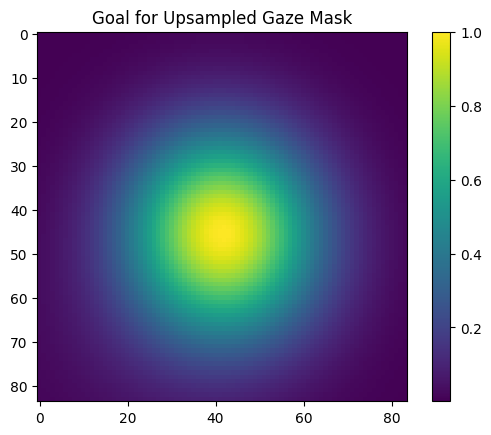

In [5]:
import matplotlib.pyplot as plt

plt.title("Goal for Upsampled Gaze Mask")
plt.imshow(gaze_targs.squeeze())
plt.colorbar()
plt.show() 


**Downsampling the gaze mask first**
(1, 84, 84) ---> (6, 6)

In [6]:
gaze_preds = gaze_targs.unsqueeze(0)
gaze_preds = F.interpolate(gaze_preds, size=(6,6), mode='nearest')
gaze_preds = gaze_preds.squeeze(0)
gaze_preds, gaze_preds.shape

(tensor([[[0.0011, 0.0041, 0.0125, 0.0179, 0.0111, 0.0029],
          [0.0043, 0.0306, 0.1038, 0.1513, 0.0943, 0.0252],
          [0.0149, 0.1136, 0.3864, 0.5673, 0.3578, 0.0973],
          [0.0284, 0.1982, 0.6626, 0.9789, 0.6291, 0.1761],
          [0.0327, 0.1794, 0.5605, 0.8241, 0.5406, 0.1568],
          [0.0267, 0.0989, 0.2575, 0.3604, 0.2375, 0.0708]]]),
 torch.Size([1, 6, 6]))

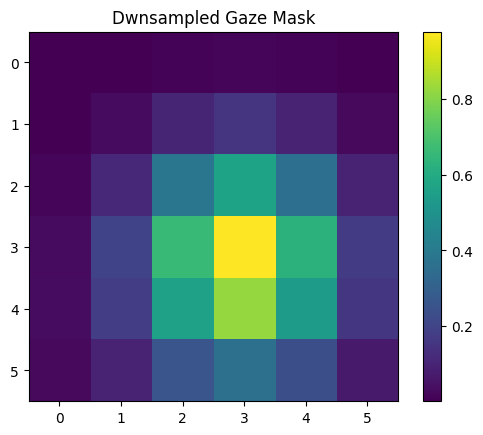

In [7]:
import matplotlib.pyplot as plt

plt.title("Dwnsampled Gaze Mask")
plt.imshow(gaze_preds.squeeze())
plt.colorbar()
plt.show() 


**Gaze Targets** has size **(B, H, W)**

- B: batch size
- H: image height (pixels)
- W: image width (pixels)

**Gaze Preds** has size **(B, h, p)**

- B: batch size (same as above)
- h: number of attention heads
- p: number of patches (smaller than H×W)

**torch.upsample()**
 - (b, 1, p) --> (b, 1, H*W)
 - size: (output size)
 - mode: default is "nearest"

In [11]:
gaze_preds = gaze_preds.unsqueeze(1)
gaze_preds = F.interpolate(gaze_preds, size=(H,W), mode='nearest')
gaze_preds = gaze_preds.squeeze(1)
gaze_preds.shape

torch.Size([1, 84, 84])

(b, 1, H * W) ---> (b, H * W)

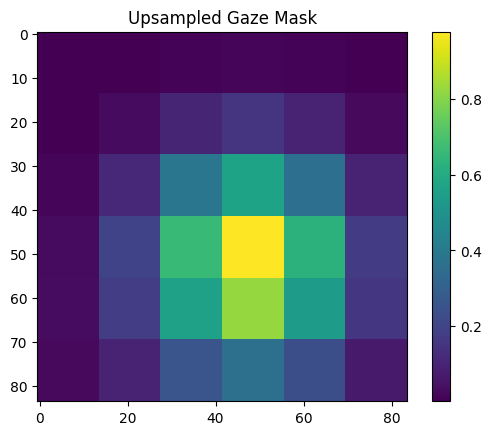

In [12]:
plt.title("Upsampled Gaze Mask")
plt.imshow(gaze_preds.squeeze())
plt.colorbar()
plt.show()